### Classification Task

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets
from torch.utils.data import SubsetRandomSampler

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


## Dataset

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transforms.ToTensor())

print(f"Train dataset : {train_dataset}")
print(f"Test dataset  : {test_dataset}")

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
sample_index = 0
num_labels = len(label_names)
image = train_dataset[sample_index][0]
label = label_names[train_dataset[sample_index][1]]

print(f'PyTorch tensor shape: {image.shape}')
print(f'PyTorch tensor type: {image.dtype}')

Train dataset : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test dataset  : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test
    StandardTransform
Transform: ToTensor()
PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## Convolutional Network

In [3]:
# #good convolutinal neural network architecture, 88% accuracy with 150 epochs, v1
# class myCNN(nn.Module):
    
#     def __init__(self):
#         super().__init__()
        
#         ### Convolutional section
#         self.conv = nn.Sequential(
#             # First convolutional layer
#             nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=5),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # Second convolutional layer
#             nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         ### Flatten layer
#         self.flatten = nn.Flatten(start_dim=1)

#         ### Linear section
#         self.lin = nn.Sequential(
#             # First linear layer
#             nn.Linear(in_features=12*4*4, out_features=64),
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),
#             # Second linear
#             nn.Linear(in_features=64, out_features=32),
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),

#             nn.Linear(in_features=32, out_features=10),
#             nn.ReLU(True),

#             # we don't need softmax since we'll use cross entropy loss
#         )
        
#     def forward(self, x):
#         # Apply convolutions
#         x = self.conv(x)
#         # Flatten
#         x = self.flatten(x)
#         # # Apply linear layers
#         x = self.lin(x)
#         return x

In [4]:
#V2
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=16, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*4*4, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=32, out_features=10),
            nn.ReLU(True),

            # we don't need softmax since we'll use cross entropy loss
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.conv(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.lin(x)
        return x

## Training

In [5]:
# Training function
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    # Set the model to training mode
    model.train()
    # Initialize the loss
    running_loss = 0
    train_loss = []
    # Loop over the training batches
    for (data, label) in dataloader:
        # target = onehot encoding of label
        target = torch.eye(10)[label] 
        # Move the input and target data to the selected device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(data)
        assert output.shape == target.shape
        # Compute the loss
        loss = loss_fn(output, target)
        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        #batch loss
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    # Return the average training loss
    train_loss = np.mean(train_loss)
    #print(f"Training loss: {train_loss}")
    return train_loss

#validation function
def validate_epoch(model, dataloader, loss_fn, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the validation loss
    val_loss = []
    # Loop over the validation batches
    with torch.no_grad():
        for (data, label) in dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # Compute the output
            output = model(data)
            assert output.shape == target.shape
            # Compute the loss
            loss = loss_fn(output, target)
            #batch loss
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    # Return the average validation loss
    val_loss = np.mean(val_loss)
    #print(f"Validation loss: {val_loss}")
    return val_loss

#reset weights function
def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
            layer.reset_parameters()

# plot and save validation loss
def plot_and_save_losses_and_accuracy(comb_val_losses, model_name):
    fig = plt.figure(figsize=(8,3))
    plt.plot(comb_val_losses, label='Validation loss', color='red')
    plt.ylim(0,2)
    plt.title(f"{model_name} Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    fig.savefig(f"images/{model_name}_val_loss.eps", format="eps", dpi=1000, bbox_inches="tight")
    plt.show()
    plt.close()

#get the percentage of correct predictions on the test set
def get_accuracy(net, dataloader, loss_fn, device):
    correct = 0
    total = 0
    net.eval()
    losses = []
    with torch.no_grad():
        for (data, label) in dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label]
            # Move the input and target data to the selected device
            data, label, target = data.to(device), label.to(device), target.to(device)
            # Compute the output
            output = net(data)
            assert output.shape == target.shape
            # Compute the loss
            loss = loss_fn(output, target)
            losses.append(loss.detach().cpu().numpy())
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum().item()
            # Add to the total number of predictions
            total += data.shape[0]
    # Return the accuracy and test loss
    test_loss = np.mean(losses)
    return correct/total, test_loss

## Cross-validation Training and Hyperparameters Tuning
Note: in this case weights are not reset at every new fold, otherwise the training would take too long. This makes the validation loss not 100% correct, and we need to take that into account when looking at the plots.

In [6]:
torch.manual_seed(42)
## Parameters
#batch size
batch_sizes = [256, 1024]#[32, 64, 128, 256, 512, 1024]
#learning rate
learning_rates = [5e-4, 1e-3, 5e-3, 1e-2] #[5e-4, 1e-3, 5e-3, 1e-2]
#optimiizer
optimizers = [torch.optim.Adam] #[torch.optim.Adam, torch.optim.SGD]
optimizer_names = ["Adam"]
#epochs ## NOTE: the total number of epochs is epochs*k_folds
epochs = 10
#k-folds
k_folds = 3
#test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #try big bs


In [7]:
# # losses = np.zeros((len(batch_sizes), len(learning_rates), len(optimizers), epochs))
# losses = np.zeros((len(batch_sizes), len(learning_rates), len(optimizers), epochs*k_folds))
# num_tot_combinations = len(batch_sizes) * len(learning_rates) * len(optimizers)
# comb = 0
# for b, batch_size in enumerate(batch_sizes):
#     for l, lr in enumerate(learning_rates):
#         for o, (optim, optim_name) in enumerate(zip(optimizers, optimizer_names)):
#             print(f"__________________{comb+1}/{num_tot_combinations}_______________________")
#             print(f"BS: {batch_size}, optim: {optimizer_names[o]}, lr: {lr:.0e}, epochs: {epochs*k_folds}")
#             comb += 1
#             #create model
#             model = myCNN().to(device)
#             #create loss function
#             loss_fn = nn.CrossEntropyLoss()
#             #create optimizer
#             optimizer = optim(model.parameters(), lr=lr)
#             #K-fold
#             kf = KFold(n_splits=k_folds, shuffle=True)
#             #comb_val_losses = np.zeros(epochs)
#             comb_val_losses = []
#             for fold, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
#                 #reset weights
#                 #reset_weights(model) #no reset
#                 #create dataloaders
#                 train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
#                                         sampler=SubsetRandomSampler(train_ids))
#                 val_dataloader = DataLoader(train_dataset, batch_size=10_000, #try big bs for val
#                                         sampler=SubsetRandomSampler(val_ids))
#                 #train model
#                 #val_loss_log = [] #not needed anymore
#                 for epoch in tqdm(range(epochs)):
#                     train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
#                     val_loss = validate_epoch(model, val_dataloader, loss_fn, device)
#                     #val_loss_log.append(val_loss) #not needed anymore
#                     comb_val_losses.append(val_loss)
#                 #comb_val_losses += np.array(val_loss_log) / k_folds #not needed anymore
#             #store losses
#             comb_val_losses = np.array(comb_val_losses)
#             losses[b, l, o, :] = comb_val_losses
#             #complete training on the whole dataset  #not needed anymore
#             #reset_weights(model) #no reset
#             # we use the training already done
#             # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#             # for epoch in tqdm(range(epochs)):
#             #     _ = train_epoch(model, train_dataloader, loss_fn, optimizer, device)

#             #plot and save losses
#             model_name = f"CNN_{batch_size}_{optim_name}_{lr:.0e}"
#             print(f"model name: {model_name}")
#             accuracy, test_loss = get_accuracy(model, test_dataloader, loss_fn, device)
#             print(f"Test loss: {test_loss:.4f}")
#             print(f"Test accuracy: {(accuracy*100):.4f}")
#             plot_and_save_losses_and_accuracy(comb_val_losses, model_name)



# Final Training loop

In [8]:
#set seed
torch.manual_seed(42)

# Instantiate the model
cnn = myCNN().to(device)

# define the loss function
loss_fn = nn.CrossEntropyLoss()

#define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=7e-3) #lr = 1e-3

#dataloadeers
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True) #256
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False) #try big bs

In [9]:
# decide to train or not
load_good_model = True # if True do not train a new model, if False train a new model
good_model_path =  'good_models/cnn_v2_epoch_39.pth'#"good_models/cnn_v1_epoch_200.pth"
loss_file = 'good_models/losses_v2_39.pkl' #'good_models/losses_v1_200.pkl'

In [10]:
#create a folder called training to save the model
import pickle
if not load_good_model:
    if not os.path.exists('training'):
        os.makedirs('training')
    #clear the training folder
    if os.listdir('training'):
        for f in os.listdir('training'):
            os.remove(os.path.join('training', f))

# early stopping helper function
def early_stopping(latest_val_losses, best_loss, model, cnt, epoch, increment=0.02, patience=5):
    if epoch < 4:
        return best_loss, cnt, False
    curr_loss = np.mean(latest_val_losses[-3:])
    if curr_loss < best_loss:
        best_loss = curr_loss
        print(f"best loss: {best_loss:.4f}, curr_loss: {curr_loss:.4f}")
        #save the model
        torch.save(model.state_dict(), f"training/cnn_epoch_{epoch+1}.pth")
        cnt = 0
    elif curr_loss > (1+increment)*best_loss:
        cnt += 1
        print(f" ADDING 1 best loss: {best_loss:.4f}, curr_loss: {curr_loss:.4f}")
        if cnt >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            return best_loss, cnt, True
    else:  
        cnt = 0
    return best_loss, cnt, False           

In [11]:
# training loop
train_losses = []
test_losses = []
if not load_good_model:
    num_epochs = 50 #150
    #for early stopping
    early_stopping_cnt = 0
    best_loss = np.inf 
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        # Train the model
        train_loss = train_epoch(cnn, train_dataloader, loss_fn, optimizer, device)
        # Validate the model
        val_loss = validate_epoch(cnn, test_dataloader, loss_fn, device)
        print(f"Test loss: {val_loss}")
        # Append the losses
        train_losses.append(train_loss)
        test_losses.append(val_loss)

        # early stopping and saving the model
        best_loss, early_stopping_cnt, early_stopping_flag = early_stopping(test_losses, best_loss, cnn, early_stopping_cnt, epoch)
        if early_stopping_flag:
            break
    # Save the losses
    with open('training/losses.pkl', 'wb') as f:
        pickle.dump([train_losses, test_losses], f)
else:
    #load the model
    cnn.load_state_dict(torch.load(good_model_path))
    #load the losses
    with open(loss_file, 'rb') as f:
        [train_losses, test_losses] = pickle.load(f)

## Losses and model accuracy

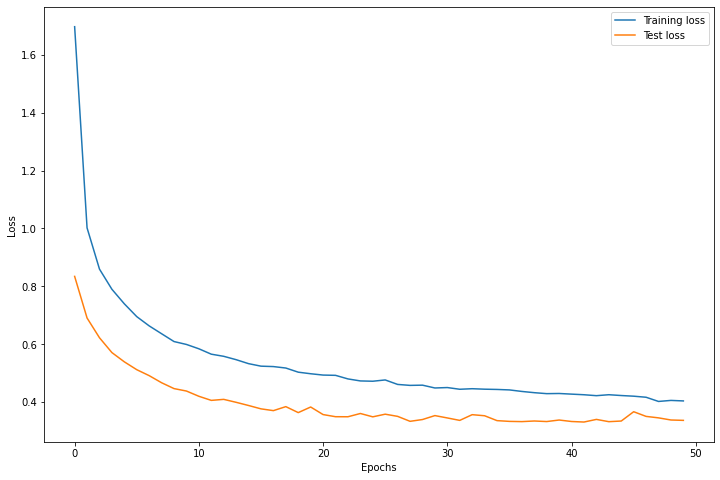

In [12]:
# Plot the training and validation losses
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train_losses, label='Training loss')
ax.plot(test_losses, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [13]:

accuracy, test_loss = get_accuracy(cnn, test_dataloader, loss_fn, device)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {(accuracy*100):.2f}")

Test loss: 0.3329
Test accuracy: 89.23


## Confusion Matrices

In [14]:
# function to get all predictions
def get_predictions(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()
    # Initialize the predictions
    predictions = []
    # Loop over the test batches
    with torch.no_grad():
        for (data, label) in tqdm(dataloader):
            # Move the input and target data to the selected device
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = model(data)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the predictions
            predictions.extend(pred.cpu().numpy().tolist())
    return predictions

#define dataloaders with no shuffle
train_dataloader = DataLoader(train_dataset, batch_size=10000, shuffle=False)

#get train dataset predictions
train_predictions = get_predictions(cnn, train_dataloader, device)
# get test dataset predictions
test_predictions = get_predictions(cnn, test_dataloader, device)

#get the labels
train_labels = []
for data, label in tqdm(train_dataloader): #note: to have a reasonable cm, dataloader needs to be without shuffle
    train_labels.extend(label.numpy())

test_labels = []
for data, label in tqdm(test_dataloader):
    test_labels.extend(label.numpy())

print(f"Train labels: {train_labels[:10]}")
print(f"Train predictions: {train_predictions[:10]}")
print(f"Test labels: {test_labels[:10]}")
print(f"Test predictions: {test_predictions[:10]}")

# calculate confusion matrix for train and test set 
import sklearn.metrics as metrics
cm_train = metrics.confusion_matrix(train_labels, train_predictions)
cm_test = metrics.confusion_matrix(test_labels, test_predictions)

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

Train labels: [9, 0, 0, 3, 0, 2, 7, 2, 5, 5]
Train predictions: [[9], [0], [0], [3], [0], [2], [7], [2], [5], [5]]
Test labels: [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
Test predictions: [[9], [2], [1], [1], [6], [1], [4], [6], [5], [7]]


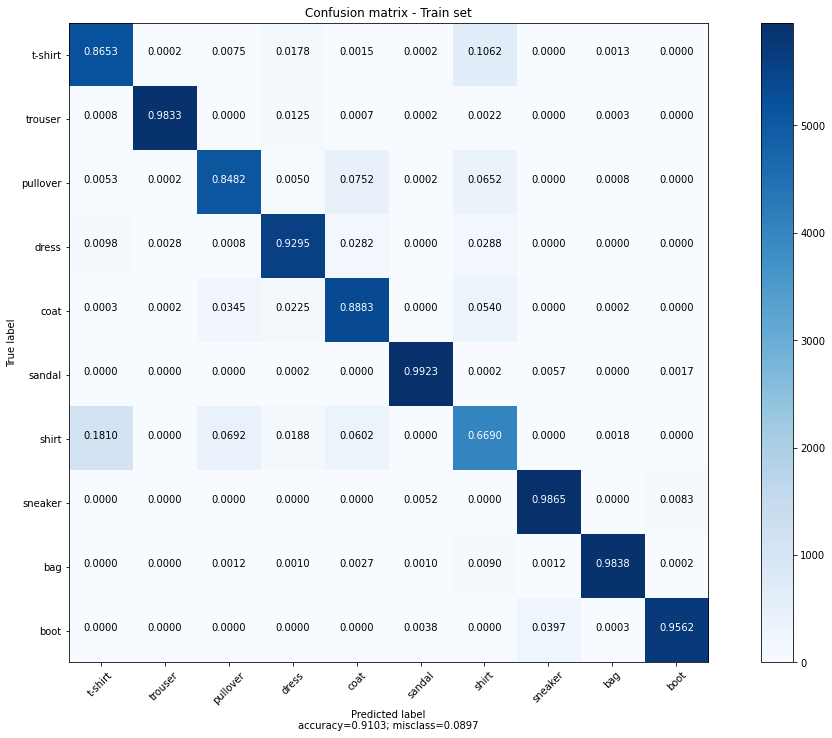

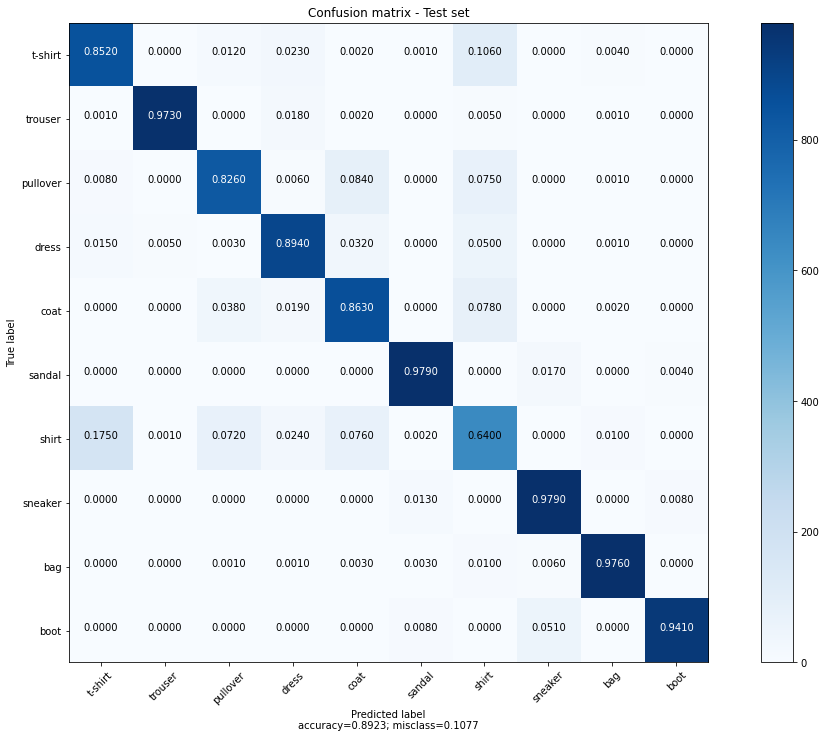

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm_train, target_names=label_names, title='Confusion matrix - Train set')
plot_confusion_matrix(cm_test, target_names=label_names, title='Confusion matrix - Test set')

Apparently, shirts can be confused more easily with t-shirts, coats and pullover. 

## Network Analysis
### Weight Histograms

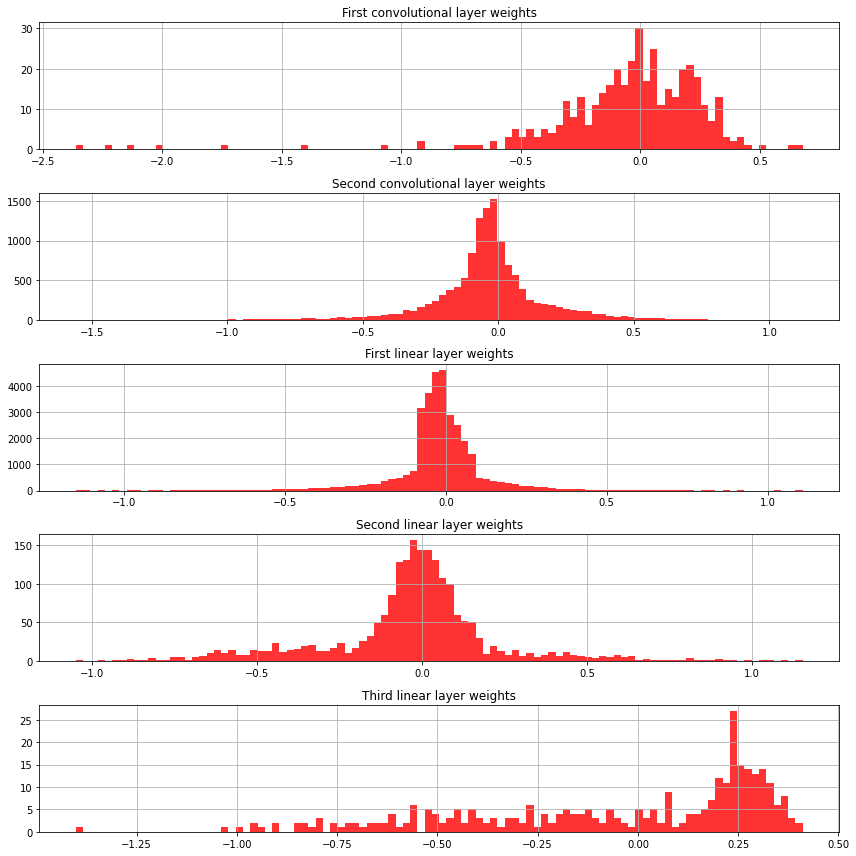

In [16]:
# Convolutional layers
c1w = cnn.conv[0].weight.data.cpu().numpy()
c1b = cnn.conv[0].bias.data.cpu().numpy()
c2w = cnn.conv[3].weight.data.cpu().numpy()
c2b = cnn.conv[3].bias.data.cpu().numpy()

# Linear layers
l1w = cnn.lin[0].weight.data.cpu().numpy()
l1b = cnn.lin[0].bias.data.cpu().numpy()
l2w = cnn.lin[3].weight.data.cpu().numpy()
l2b = cnn.lin[3].bias.data.cpu().numpy()
l3w = cnn.lin[6].weight.data.cpu().numpy()
l3b = cnn.lin[6].bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,12))
axs[0].hist(c1w.flatten(), bins=100, color='r', alpha=0.8, label='Conv1')
axs[0].set_title('First convolutional layer weights')
axs[1].hist(c2w.flatten(), bins=100, color='r', alpha=0.8, label='Conv2')
axs[1].set_title('Second convolutional layer weights')
axs[2].hist(l1w.flatten(), bins=100, color='r', alpha=0.8, label='Lin1')
axs[2].set_title('First linear layer weights')
axs[3].hist(l2w.flatten(), bins=100, color='r', alpha=0.8, label='Lin2')
axs[3].set_title('Second linear layer weights')
axs[4].hist(l3w.flatten(), bins=100, color='r', alpha=0.8, label='Lin3')
axs[4].set_title('Third linear layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Convolutional filters / Receptive Fields

In [17]:
print(cnn)

myCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): ReLU(inplace=True)
  )
)


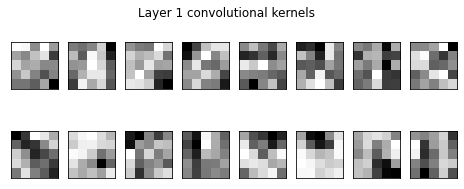

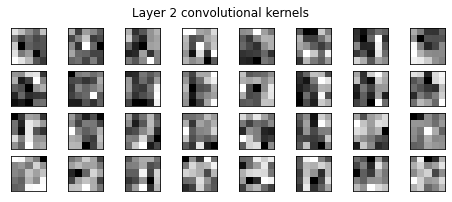

In [18]:
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,3))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(c1w, 2, 8, 'Layer 1 convolutional kernels')
plot_nchw_data(c2w, 4, 8, 'Layer 2 convolutional kernels')

myCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): ReLU(inplace=True)
  )
)


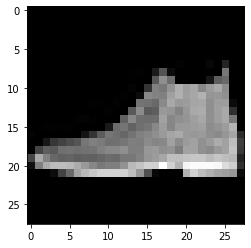

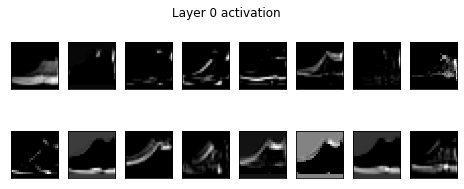

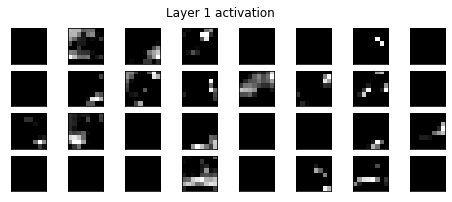

In [19]:
## Convolutional section activation
print(cnn)
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(cnn.conv[1].register_forward_hook(hook_fn))
hook_handles.append(cnn.conv[4].register_forward_hook(hook_fn))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
#get first image from the test dataloader
image, label = iter(test_dataloader).next()
# show the image
plt.imshow(image.squeeze(), cmap='gray')
image, label = image.to(device), label.to(device)
#evaluate output
cnn.eval()
with torch.no_grad():
    intermediate_outputs = []
    output = cnn(image)
for handle in hook_handles:
  handle.remove()

for layer_num, intermediate_output in enumerate(intermediate_outputs):
    intermediate_output = intermediate_output.cpu().data.numpy()
    plot_nchw_data(intermediate_output, 2*(layer_num+1), 8, 'Layer {} activation'.format(layer_num))


### Last layer activations

t-shirt - confidence: 0.982835054397583
trouser - confidence: 1.0
pullover - confidence: 0.9988439083099365
dress - confidence: 0.9981551766395569
coat - confidence: 0.9913045167922974
sandal - confidence: 1.0
shirt - confidence: 0.9503623247146606
sneaker - confidence: 0.9999977350234985
bag - confidence: 1.0
boot - confidence: 0.9930826425552368


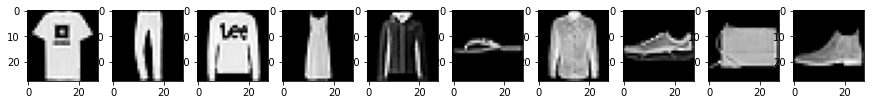

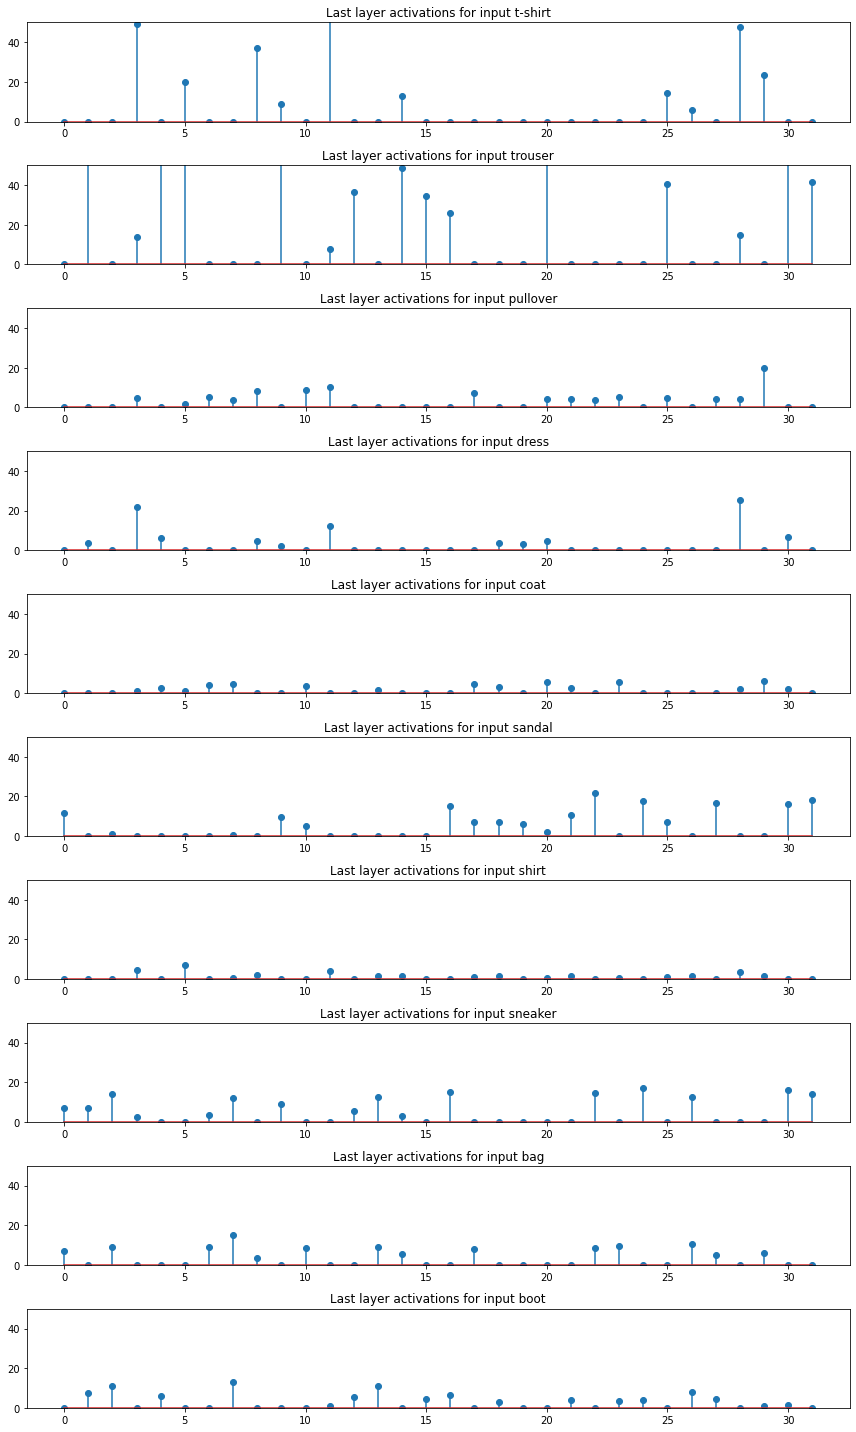

In [20]:
## Last layer activations
# attach an hook to last linear layer
def hook_function(module, input, output):
    global activation
    activation = output
    

# find an input for each class for which the cnn is very confident
fig, axs = plt.subplots(1, 10, figsize=(15,6))
inputs = []
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
cnn.eval()
for i in range(10):
    found = False
    for (image, label) in test_dataloader:
        if label == i:
            image, label = image.to(device), label.to(device)
            output = cnn(image)
            output = torch.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            confidence = output.detach().cpu().numpy()[0][i]
            # check if the prediction is correct
            if pred == label and confidence > 0.95:
                print(f"{label_names[i]} - confidence: {confidence}")
                inputs.append(image)
                # plot image
                axs[i].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
                found = True
                break
    if not found:
        print(f"{label_names[i]} not found")
plt.show()
                
#register hook
hook_handle = cnn.lin[3].register_forward_hook(hook_function)

#analyze activations
cnn = cnn.to(device)
cnn.eval()
activations = []
with torch.no_grad():
    for i in inputs:
        out = cnn(i)
        zi = activation.cpu().numpy()
        activations.append(zi)

#remove hook
hook_handle.remove()

fig, axs = plt.subplots(10, 1, figsize=(12, 20))
for i in range(10):
    act = activations[i][0]
    axs[i].stem(act, use_line_collection=True)
    axs[i].set_title(f"Last layer activations for input {label_names[i]}")
    axs[i].set_ylim([0, 50])
plt.tight_layout()
plt.show()
